In [1]:
import sys
from kaitoupao import *

storage dir: /Users/minkexiu/Downloads/GitHub/Tianchi_NLPNewsClassification
code dir: /Users/minkexiu/Documents/GitHub/Tianchi_NLPNewsClassification 

21 09 52
先天八卦数: 1乾, 2兑, 3离, 4震, 5巽, 6坎, 7艮, 8坤
本卦上：5 本卦下：1 变爻：4


,风天小畜,火泽睽,天天乾
上卦,☴巽木,☲离火,☰乾金
下卦,☰乾金,☱兑金,☰乾金


12 22 6 巳时
先天八卦数: 1乾, 2兑, 3离, 4震, 5巽, 6坎, 7艮, 8坤
本卦上：4 本卦下：6 变爻：6


,雷水解,水火既济,火水未济
上卦,☳震木,☵坎水,☲离火
下卦,☵坎水,☲离火,☵坎水


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
device = torch.device("mps")

# 加载训练集和测试集，将全量字符列表给它弄出来

In [5]:
data_train = pd.read_csv(create_originalData_path("train_set.csv"), sep="\t", )#.sample(1000)
data_test = pd.read_csv(create_originalData_path("test_a.csv"), sep="\t", )#.sample(1000)

In [6]:
data_train.shape, data_test.shape

((200000, 2), (50000, 1))

In [7]:
type_of_class = data_train.label.nunique()

In [8]:
train_data, valid_data = train_test_split(data_train, test_size=0.3, random_state=42)

In [9]:
train_labels = torch.tensor(train_data.label.to_list(), dtype=torch.long)
valid_labels = torch.tensor(valid_data.label.to_list(), dtype=torch.long)
test_labels = torch.tensor([-1 for x in range(data_test.shape[0])], dtype=torch.long) ## test_labels的label是假的。

## 使用TF-IDF提取特征

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_train_features = tfidf_vectorizer.fit_transform(train_data['text'])
tfidf_valid_features = tfidf_vectorizer.transform(valid_data['text'])
tfidf_test_features = tfidf_vectorizer.transform(data_test['text'])

In [11]:
train_features = torch.tensor(tfidf_train_features.toarray(), dtype=torch.float32)
valid_features = torch.tensor(tfidf_valid_features.toarray(), dtype=torch.float32)
test_features = torch.tensor(tfidf_test_features.toarray(), dtype=torch.float32)

In [12]:
sc_input_dim = train_features.shape[1]
sc_input_dim

6695

## 创建适合于语言序列的数据

In [13]:
# 下载数据并进行预处理
vocab_size = 8000  # 只考虑前 20k 词汇
maxlen = 800  # 只考虑每条评论的前 200 个词

In [14]:
def preprocess_seq_str_2_int(seq, len_lim = maxlen):
    rst = [int(wd) for idx, wd in enumerate(seq.strip().split()) if idx < len_lim]
    return rst

In [15]:
x_train = [torch.tensor(preprocess_seq_str_2_int(seq), dtype=torch.long) for seq in train_data.text]
x_valid = [torch.tensor(preprocess_seq_str_2_int(seq), dtype=torch.long) for seq in valid_data.text]
x_test = [torch.tensor(preprocess_seq_str_2_int(seq), dtype=torch.long) for seq in data_test.text]

In [16]:
x_train = pad_sequence(x_train, batch_first=True, padding_value=0)
x_valid = pad_sequence(x_valid, batch_first=True, padding_value=0)
x_test = pad_sequence(x_test, batch_first=True, padding_value=0)

## 准备数据集

In [17]:
batchsize = 32

In [18]:
class MyData(Dataset):
    def __init__(
        self, 
        ori_data, tfidf_feats, label,
    ):
        self.ori_data = ori_data
        self.tfidf_feats = tfidf_feats
        self.label = label
 
    def __len__(self):
        return len(self.ori_data)
 
    def __getitem__(self, idx):
        tuple_ = (
            self.ori_data[idx], 
            self.tfidf_feats[idx], 
            self.label[idx]
        )
        return tuple_

In [19]:
train_loader = DataLoader(MyData(x_train, train_features, train_labels), batch_size=batchsize, shuffle=True,)
val_loader = DataLoader(MyData(x_valid, valid_features, valid_labels), batch_size=batchsize, shuffle=True,)
test_loader = DataLoader(MyData(x_test, test_features, test_labels), batch_size=batchsize, shuffle=True,)

# 定义网络结构

In [20]:
from transformers import BertConfig
from transformers import BertForSequenceClassification

In [21]:
# 单层神经网络：
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
 
    def forward(self, x):
        return self.fc(x)

In [22]:
# 定义模型
class TransformerModel(nn.Module):
    def __init__(self, maxlen, vocab_size, embed_dim, num_heads, ff_dim):
        super(TransformerModel, self).__init__()
        # self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        # self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        # self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        # self.dropout1 = nn.Dropout(0.1)
        # self.dense1 = nn.Linear(embed_dim, 20)
        # self.dropout2 = nn.Dropout(0.1)
        # self.dense2 = nn.Linear(20, type_of_class)

        ## https://www.kdnuggets.com/how-to-build-and-train-a-transformer-model-from-scratch-with-hugging-face-transformers
        self.bert = BertForSequenceClassification(
            BertConfig(
                vocab_size=vocab_size,
                hidden_size=32,
                num_hidden_layers=4,
                num_attention_heads=2,
                intermediate_size=64,
                max_position_embeddings=maxlen,
                num_labels=type_of_class
            )
        )

        self.sc_net = SentimentClassifier(sc_input_dim, type_of_class)
        
    def forward(self, x, x_tfidf):
        # x = self.embedding_layer(x).transpose(0, 1)  # Transformer expects (seq_len, batch_size, embed_dim)
        # x = self.transformer_block(x)
        # x = x.transpose(0, 1)
        # x = self.global_avg_pool(x.permute(0, 2, 1)).squeeze(-1)
        # x = self.dropout1(x)
        # x = F.relu(self.dense1(x))
        # x = self.dropout2(x)
        
        return F.log_softmax(self.bert(x).logits + self.sc_net(x_tfidf), dim=-1)

# 构建模型以及训练

In [23]:
model = TransformerModel(maxlen, vocab_size, embed_dim=64, num_heads=4, ff_dim=32)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [24]:
model

TransformerModel(
  (bert): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(8000, 32, padding_idx=0)
        (position_embeddings): Embedding(800, 32)
        (token_type_embeddings): Embedding(2, 32)
        (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-3): 4 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=32, out_features=32, bias=True)
                (key): Linear(in_features=32, out_features=32, bias=True)
                (value): Linear(in_features=32, out_features=32, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=32, out_features=32, bias=True

In [25]:
# 训练和评估模型
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=2):
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for inputs, input_tfidfs, targets in tqdm.tqdm(train_loader):
            inputs, input_tfidfs, targets = inputs.to(device), input_tfidfs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, input_tfidfs)
            loss = criterion(outputs, targets)
            loss.requires_grad_(True)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss/len(train_loader)}, Accuracy: {100.*correct/total}%')
        
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            total_predicted = []
            total_label = []
            for inputs, input_tfidfs, targets in tqdm.tqdm(val_loader):
                inputs, input_tfidfs, targets = inputs.to(device), input_tfidfs.to(device), targets.to(device)
                outputs = model(inputs, input_tfidfs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                total_predicted += list(predicted.cpu())
                total_label += list(targets.cpu())
        f1 = f1_score(total_label, total_predicted, average='macro')
                
        print(f'Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100.*correct/total}%, f1 score is {f1}')

In [26]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1)

100%|███████████████████████████████████████| 4375/4375 [11:43<00:00,  6.21it/s]


Epoch 1/1, Loss: 0.5415656529239246, Accuracy: 85.44714285714285%


100%|███████████████████████████████████████| 1875/1875 [00:58<00:00, 32.02it/s]


Validation Loss: 0.27066038935383163, Accuracy: 92.13333333333334%, f1 score is 0.8999066825124797


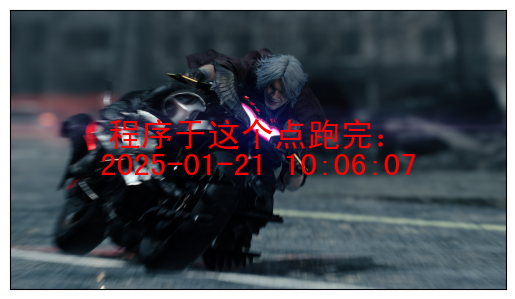

In [27]:
run_finish()

In [28]:
## 可以有一些优化，比如说我们用padding来给句子补长度到maxlen的时候，顺便再生成一个mask_id，这个东西啊，
## bert能用得上。

## 还有就是tfidf这个特征，或许可以用更复杂的网络来学习。

## tfidf特征的权重或许也可以调整一下。或许可以尝试把各种网络的输出结果混合起来后再乘以一个变量，得到最终的输出结果。
## 假设我们用了bert、tfidf、wob三个网络，我们就把它们的结果以concat成（3，14），然后reshape成（14，3）之后乘以一个（3，1）的层，变成（14，1）再reshape成（1，14）作为最终输出。
## 或者直接concat起来之后得到（1，3*14），再过一个（3*14，14）的层变成（1，14）输出。
## 为什么呢，因为原来的输出组合方式有点武断，就是三者权重一致。这个感觉不太合理，因为肯定是bert的结果要更牛逼啊，它的权重肯定要大一些才好。

## 如果有

In [29]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

100%|███████████████████████████████████████| 4375/4375 [11:44<00:00,  6.21it/s]


Epoch 1/5, Loss: 0.24579240153091295, Accuracy: 92.77857142857142%


100%|███████████████████████████████████████| 1875/1875 [00:59<00:00, 31.71it/s]


Validation Loss: 0.22871977375845115, Accuracy: 93.18166666666667%, f1 score is 0.9150080852097525


100%|███████████████████████████████████████| 4375/4375 [11:49<00:00,  6.17it/s]


Epoch 2/5, Loss: 0.19864480361150844, Accuracy: 93.98%


100%|███████████████████████████████████████| 1875/1875 [00:58<00:00, 31.87it/s]


Validation Loss: 0.2162951589996616, Accuracy: 93.31833333333333%, f1 score is 0.9183632769844697


100%|███████████████████████████████████████| 4375/4375 [11:55<00:00,  6.12it/s]


Epoch 3/5, Loss: 0.1720053096230541, Accuracy: 94.72214285714286%


100%|███████████████████████████████████████| 1875/1875 [00:59<00:00, 31.54it/s]


Validation Loss: 0.2214686432391405, Accuracy: 93.14666666666666%, f1 score is 0.9149856240053363


  3%|█▏                                      | 130/4375 [00:21<11:36,  6.09it/s]

KeyboardInterrupt



In [ ]:
## 恐怕上面那个918的是最好的了。

In [35]:
save_pickle_object(model, create_trained_models_path("ori_9041-dev_tfidf-bert.pkl"))

/Users/minkexiu/Downloads/GitHub/Tianchi_NLPNewsClassification/trained_models/ori_9041-dev_tfidf.pkl


In [ ]:
# train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

In [ ]:
# train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1)

In [ ]:
# train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1)

# 预测一下试试

In [ ]:
with torch.no_grad():
    total_predicted = []
    for inputs, input_tfidfs, targets in tqdm.tqdm(test_loader):
        outputs = model(inputs, input_tfidfs)
        _, predicted = torch.max(outputs, 1)
        total_predicted += list(predicted)

In [ ]:
oot_rst = [int(x) for x in total_predicted]
len(oot_rst)

In [ ]:
store_data_to_newbasepath(pd.DataFrame({"label": oot_rst}), "rst-20250113_1", fmt="csv")

# 保存模型